# Introduction

This exercise makes use of the database you created in `Exercise02` and the BEL statement parsers you write with regular expressions in `Reading_searching_sending.ipynb`.

In [1]:
%matplotlib inline
import pandas as pd
import os, json, re, time, logging

import networkx as nx
log = logging.getLogger(__name__)
time.asctime()

'Thu Oct  6 22:10:27 2016'

In [2]:
base = os.path.join(os.environ['BUG_FREE_EUREKA_BASE'])
base

'C:\\Users\\Sakthi\\Documents\\GitHub\\bug-free-eureka'

# Task 1

This exercise is about loading the HGNC data to create a dictionary from HGNC symbols to set of enzyme ID's.

## 1.1 Load Data

Load json data from `/data/exercise02/hgnc_complete_set.json`.

In [3]:
data_path = os.path.join(base,'data','exercise02','hgnc_complete_set.json')
with open(data_path) as f:
    hgnc_json = json.load(f) # hgnc_json is a python object

## 1.2 Reorganize Data into `pd.DataFrame`

Identify the relevant subdictionaries in your `dictionary -> response -> docs`. Load them to a data frame, 
then create a new data frame with just the HGNC symbol and Enzyme ID

In [4]:
docs = hgnc_json['response']['docs']
df_hgnc = pd.DataFrame(docs)

list(df_hgnc.columns)

['_version_',
 'alias_name',
 'alias_symbol',
 'bioparadigms_slc',
 'ccds_id',
 'cd',
 'cosmic',
 'date_approved_reserved',
 'date_modified',
 'date_name_changed',
 'date_symbol_changed',
 'ena',
 'ensembl_gene_id',
 'entrez_id',
 'enzyme_id',
 'gene_family',
 'gene_family_id',
 'hgnc_id',
 'homeodb',
 'horde_id',
 'imgt',
 'intermediate_filament_db',
 'iuphar',
 'kznf_gene_catalog',
 'lncrnadb',
 'location',
 'location_sortable',
 'locus_group',
 'locus_type',
 'lsdb',
 'mamit-trnadb',
 'merops',
 'mgd_id',
 'mirbase',
 'name',
 'omim_id',
 'orphanet',
 'prev_name',
 'prev_symbol',
 'pseudogene.org',
 'pubmed_id',
 'refseq_accession',
 'rgd_id',
 'snornabase',
 'status',
 'symbol',
 'ucsc_id',
 'uniprot_ids',
 'uuid',
 'vega_id']

## 1.3 Build dictionary for lookup

Iterate over this dataframe to build a dictionary that is `{hgnc symbol: set of enzyme id's}`. Call this dictionary `symbol2ec`

In [5]:
df_hgnc[['hgnc_id','symbol','enzyme_id']].head(5)
#diff between symbol and id - symbol changes and ids remain constant, unique

,hgnc_id,symbol,enzyme_id
0,HGNC:5,A1BG,NaN
1,HGNC:37133,A1BG-AS1,NaN
2,HGNC:24086,A1CF,NaN
3,HGNC:7,A2M,NaN
4,HGNC:27057,A2M-AS1,NaN


In [6]:
symbol2ec = {}

df_hgnc_sliced = df_hgnc[['symbol','enzyme_id']]

In [7]:
for ids, symbol, enzyme_ids in df_hgnc_sliced.itertuples(): # itertuples is a method
    if isinstance(enzyme_ids,list):
        symbol2ec[symbol] = set(enzyme_ids) # to check for the membership (whether the value exists in the set)
    else:
        symbol2ec[symbol] = []

In [8]:
'AKT1' in symbol2ec

True

# Task 2

This subexercise is about validating protein and kinase activity statements in BEL. Refer to last Thursday's work in `Reading_searching_sending.ipynb`.

## 2.1 Valid HGNC

Write a function, `valid_hgnc(hgnc_symbol, symbol2ec_instance)` that takes a name and the dictionary from Task 1.3 and returns whether this is a valid name

In [9]:
def valid_hgnc(hgnc_symbol, symbol2ec_instance):
    if hgnc_symbol in symbol2ec_instance:
        return True
    else:
        return False
#   return hgnc_symbol in symbol2ec_instance

assert valid_hgnc('AKT1', symbol2ec)
assert not valid_hgnc('bla bla', symbol2ec)

# when it is true it doesn't return anything and when it if false it throws an error

## 2.2 Valid Kinase Activity

Write a function, `valid_kinase(hgnc_symbol, symbol2ec_instance)` that takes a name and the dictionary from Task 1.3 and returns whether this protein has kinase activity. Hint: an enzyme code reference can be found [here](http://brenda-enzymes.org/ecexplorer.php?browser=1&f[nodes]=132&f[action]=open&f[change]=153)

In [10]:
symbol2ec['AKT1'],symbol2ec['PIK3CA'],symbol2ec['AKT2']

({'2.7.11.1'}, {'2.7.1.153'}, {'2.7.11.1'})

In [11]:
def valid_kinase(hgnc_symbol, symbol2ec_instance):
    """
    check if symbol is valid hgnc and if it is a kinase
    param hgnc_symbol : strings representing a hgnc symbol
    param symbol2ec_instance a dictionary of HGNC symbol with EC number
    """
    if not valid_hgnc(hgnc_symbol, symbol2ec_instance):
        return False
# what makes this true?
# symbol2ec_instance[hgnc_symbol] is a list of EC id's
    
    for i in symbol2ec_instance[hgnc_symbol]:
        if i.startswith('2.7.'):
            return True
    return False
    
assert valid_kinase('AKT1', symbol2ec)
assert not valid_kinase('AKT', symbol2ec)

In [12]:
match_protein = re.compile('p\(HGNC:(?P<name>\w+)\)')
match_protein.match('p(HGNC:ABC)').groupdict()
match_kin = re.compile('kin\(p\(HGNC:(?P<name>\w+)\)\)')
match_kin.match('kin(p(HGNC:ABC))').groupdict()

{'name': 'ABC'}

## 2.3 Putting it all together

Write a function, `validate_bel_term(term, symbol2ec_instance)` that parses a BEL term about either a protein, or the kinase activity of a protein and validates it.

```python
def validate_bel_term(term, symbol2ec_instance):
    pass
```

### Examples

```python
>>> # check that the proteins have valid HGNC codes
>>> validate_bel_term('p(HGNC:APP)', symbol2ec)
True
>>> validate_bel_term('p(HGNC:ABCDEF)', symbol2ec)
False
>>> # check that kinase activity annotations are only on proteins that are
>>> # actually protein kinases (hint: check EC annotation)
>>> validate_bel_term('kin(p(HGNC:APP))', symbol2ec)
False
>>> validate_bel_term('kin(p(HGNC:AKT1))', symbol2ec)
True
```

In [13]:
match_protein = re.compile('p\(HGNC:(?P<name>\w+)\)') # re is outside the function definition as we don't want to compile it againand again
match_kin = re.compile('kin\(p\(HGNC:(?P<name>\w+)\)\)')
def validate_bel_term(term, symbol2ec_instance):
    m = match_protein.match(term)
    if m:
        mm = m.groupdict()
        symbol = mm['name']
        return valid_hgnc(symbol, symbol2ec)
    m = match_kin.match(term)
    if m:
        mk = m.groupdict()
        symbol = mk['name']
        return valid_kinase(symbol,symbol2ec)
    return False
                
    

assert validate_bel_term('p(HGNC:APP)', symbol2ec)
assert validate_bel_term('kin(p(HGNC:AKT1))', symbol2ec)
assert not validate_bel_term('p(HGNC:ABCDEF))', symbol2ec)
assert not validate_bel_term('kin(p(HGNC:APP))', symbol2ec)
    

In [14]:
>>> validate_bel_term('p(HGNC:APP)', symbol2ec)

True

In [15]:
>>> validate_bel_term('p(HGNC:ABCDEF)', symbol2ec)

False

In [16]:
>>> validate_bel_term('kin(p(HGNC:APP))', symbol2ec)

False

In [17]:
>>> validate_bel_term('kin(p(HGNC:AKT1))', symbol2ec)

True

# Task 3

This task is about manual curation of text. You will be guided through translating the following text into BEL statements as strings within a python list.

## Document Definitions

Recall citations are written with source, title, then identifier as follows:

```
SET Citation = {"PubMed", "Nat Cell Biol 2007 Mar 9(3) 316-23", "17277771"}
```

Use these annotations and these namespaces:

```
DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/20131211/namespace/hgnc-human-genes.belns"

DEFINE ANNOTATION CellLocation as LIST {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}
```


## Source Text

> The following statements are from the document "BEL Exercise" in edition 00001 of the PyBEL Journal.
> The kinase activity of PI3K causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, 
> but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. 
> Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be postively correlated in the cell nuclei.
> AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cytoplasm, and ER.

In [18]:
def get_symbol(name_in):
    return list(df_hgnc[df_hgnc.name == name_in]['symbol'])[0]

In [19]:
get_symbol('AKT serine/threonine kinase 1')

'AKT1'

In [20]:
definition_statements = [
    'SET DOCUMENT name = "BEL Exercise"'
    'DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/20131211/namespace/hgnc-human-genes.belns"',
    'DEFINE ANNOTATION CellLocation AS LIST {"cell nucleus", "cytoplasm", "endoplasmic reticulum"}',
]

In [21]:
your_statements = [
    'SET Citation = {"PyBEL Journal", "BEL Exercise", "00001"}',
    'SET Evidence = "The kinase activity of PI3K causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be postively correlated in the cell nuclei. AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cyoplasm, and ER."',
    'SET CellLocation = "cytoplasm"',
    'kin(p(HGNC:PI3KCA)) -> p(HGNC:AKT1)',
    'kin(p(HGNC:PI3KCA)) -> p(HGNC:AKT2)',
    'UNSET CellLocation',
    'SET CellLocation = "endoplasmic reticulum"',
    'kin(p(HGNC:PI3KCA)) -> p(HGNC:AKT1)',
    'UNSET CellLocation',
    'SET CellLocation = "cell nucleus"',
    'p(HGNC:AKT1) positiveCorrelation p(HGNC:AKT2)',
    'UNSET CellLocation',
    'SET CellLocation = {"cell nucleus","cytoplasm","endoplasmic reticulum"}',
    'p(HGNC:AKT2) -> p(HGNC:GSK3B)',
    'UNSET CellLocation'
]

In [22]:
statements = definition_statements + your_statements

# Task 4

This task is again about regular expressions. Return to `Reading_searching_sending.ipynb` and find your regular expressions that parse the subject, predicate, and object from a statement like `p(HGNC:AKT1) pos p(HGNC:AKT2)`

## 4.1 Validating Statements

Write a function `validate_bel_statement(statement, symbol2ec)` that takes a subject, predicate, object BEL statement as a string and determines if it its subject and objects are valid.

In [23]:
valid_relations = {
    'increases',
    'positiveCorrelation',
    'negativeCorrelation',
    'decreases',
    'directlyDecreases',
    'pos',
    'directlyIncreases'
}

In [24]:
#match_protein = re.compile('p\(HGNC:(?P<name>\w+)\)') # re is outside the function definition as we don't want to compile it againand again
#match_kin = re.compile('kin\(p\(HGNC:(?P<name>\w+)\)\)')

match_both = re.compile('(p\(HGNC:(?P<prot>\w+)\)|kin\(p\(HGNC:(?P<kin>\w+)\)\))')
match_both.match('kin(p(HGNC:ABC))').groupdict() 

{'kin': 'ABC', 'prot': None}

In [25]:
my_re = re.compile('(A\s+B\s+C)')
my_re.match('A B C').group

<function SRE_Match.group>

In [26]:
my_re_string = '(A)\s+(B)\s+(C)'
re.search(my_re_string,'A B C').groups()

('A', 'B', 'C')

In [27]:
#?P means pattern
my_re_string = ('(?P<subject>A)\s+(?P<relation>B)\s+(?P<object>C)')
re.search(my_re_string,'A B C').groupdict()

{'object': 'C', 'relation': 'B', 'subject': 'A'}

In [28]:
match_relation_string = ('(?P<subject>(p\(HGNC:(?P<sp>\w+)\)|kin\(p\(HGNC:(?P<sk>\w+)\)\)))\s+(?P<relation>\w+)'
                         '\s+(?P<object>(p\(HGNC:(?P<op>\w+)\)|kin\(p\(HGNC:(?P<ok>\w+)\)\)))')
match_relation = re.compile(match_relation_string)

In [29]:
my_re_string = ('(?P<subject>(p\(HGNC:(?P<sp>\w+)\)|kin\(p\(HGNC:(?P<sk>\w+)\)\)))\s+(?P<relation>\w+)'
                '\s+(?P<object>(p\(HGNC:(?P<op>\w+)\)|kin\(p\(HGNC:(?P<ok>\w+)\)\)))')
match_relation = re.compile(my_re_string)
match_relation.search('p(HGNC:ABC) increases p(HGNC:DEF)')

<_sre.SRE_Match object; span=(0, 33), match='p(HGNC:ABC) increases p(HGNC:DEF)'>

In [30]:
match_protein = re.compile('p\(HGNC:(?P<name>\w+)\)')  
match_kin = re.compile('kin\(p\(HGNC:(?P<name>\w+)\)\)')

def validate_bel_relation(relation, symbol2ec_instance):
    """
    Validate the syntax and semantics of a relation
    :param relation: a BEL relation
    :type relation: str
    :rtype: bool
    """
    mr = match_relation.match(relation)
    if not mr:
        log.warning('Not valid relation: {}'.format(relation))
        return False
    mrg = mr.groupdict()
    
    if mrg['sp'] is None and mrg['sk'] is None:
        log.warning('No valid subject')
        return False

    if mrg['op'] is None and mrg['ok'] is None:
        log.warning('No valid object')
        return False
    
    if mrg['sk'] is None:
        if not valid_hgnc(mrg['sp'], symbol2ec_instance):
            log.warning('Semantically invalid subject - not a valid HGNC')
            return False
    else:
        if not valid_kinase(mrg['sk'], symbol2ec_instance):
            log.warning('Semantically invalid subject - {} not a kinase'.format(mrg['sk']))
            return False
    
    if mrg['ok'] is None:
        if not valid_hgnc(mrg['op'], symbol2ec_instance):
            log.warning('Semantically invalid object - not a valid HGNC')
            return False
    else:
        if not valid_kinase(mrg['ok'], symbol2ec_instance):
            log.warning('Semantically invalid object - not a kinase')
            return False
    
    if mrg['relation'] not in valid_relations:
        log.warning('invalid relation')
        return False
    
    return True

In [31]:
my_rel = 'kin(p(HGNC:APP)) increases p(HGNC:AKT2)'
validate_bel_relation(my_rel, symbol2ec) 

Semantically invalid subject - APP not a kinase


False

# 4.2 Populating a graph
Even though its a bit redundant, this function validates a relation and adds it to a networkx graph.

In [32]:
def populate_graph(graph, relation, symbol2ec_instance):
    """
    :type graph: nx.MultiDiGraph
    :type relation: str
    :type symbol2ec_instance: dict
    """
    if not validate_bel_relation(relation, symbol2ec_instance):
        return
    
    mrg = match_relation.match(relation).groupdict() 

    rel = mrg['relation']

    if mrg['sk'] is None:
        sub_name = mrg['sp']
    else:
        sub_name = mrg['sk']

    if mrg['ok'] is None:
        obj_name = mrg['op']
    else:
        obj_name = mrg['ok']

    graph.add_node(sub_name)
    graph.add_node(obj_name)
    graph.add_edge(sub_name, obj_name, relation=rel)

## 4.3 Validating Your Statements

Run this cell to validate the BEL statements you've written.

In [33]:
G = nx.MultiDiGraph()

for statement in your_statements:
    valid = validate_bel_relation(statement, symbol2ec)
    populate_graph(G, statement, symbol2ec)

Not valid relation: SET Citation = {"PyBEL Journal", "BEL Exercise", "00001"}
Not valid relation: SET Citation = {"PyBEL Journal", "BEL Exercise", "00001"}
Not valid relation: SET Evidence = "The kinase activity of PI3K causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 were found to be postively correlated in the cell nuclei. AKT serine/threonine kinase 2 increases GSK3 Beta in all of the nuclei, cyoplasm, and ER."
Not valid relation: SET Evidence = "The kinase activity of PI3K causes the increased abundance of AKT serine/threonine kinase 1 and AKT serine/threonine kinase 2 in the cytoplasm, but only the increased expression of AKT serine/threonine kinase 1 in the endoplasmic reticulum. Additionally, the abundance of AKT serine/thre

## 4.4 Visualization

Use `pybel` to visualize the network.

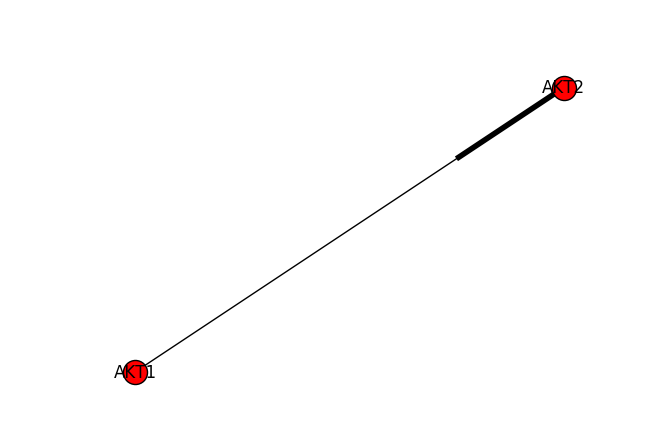

In [37]:
%matplotlib inline
nx.draw(G, with_labels=True)